In [1]:
from goose import Goose
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from textblob import TextBlob, Word
from sklearn.base import TransformerMixin
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
import datetime
import heapq
%matplotlib inline

In [2]:
use_columns = ['url_raw', 'url_clean', 'url_domain', 'ugly_text', 'issue', 'political lean', 'title', 'meta_description', 'cleaned_text']
pld = pd.read_csv('0_27439_5_06_pm_12_9_16.csv', usecols=use_columns)

In [3]:
present = pld[pld.cleaned_text.notnull()].cleaned_text.count()
print "Present: " + str(present)
print "Not Present: " + str(pld['url_raw'].count() - present)
pld_text = pld[pld.cleaned_text.notnull()]

Present: 21224
Not Present: 6216


In [336]:
pld_text.head()

,url_raw,url_clean,url_domain,ugly_text,issue,political lean,title,meta_description,cleaned_text,length,political lean integer
0,https://www.washingtonpost.com/news/post-natio...,washingtonpost.com/news/post-nation/wp/2016/05...,washingtonpost.com,2 Desktop notifications are ...,abortion,Lean Left,‘A target on Roe v. Wade ’: Oklahoma bill maki...,Gov. Mary Fallin (R) has not said if she plans...,UPDATE: Gov. Fallin vetoed the bill on Friday....,6839,2
1,http://www.salon.com/2016/04/07/camille_paglia...,salon.com/2016/04/07/camille_paglia_feminists_...,salon.com,\n\n\t\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t...,abortion,Left,"Camille Paglia: Feminists have abortion wrong,...",Reproductive rights have become ideological to...,"While the Hillary flap was merely a blip, give...",12083,1
2,http://www.vox.com/2016/3/20/11269226/texas-ab...,vox.com/2016/3/20/11269226/texas-abortion-wome...,vox.com,"\n \n \n\n(function(w,d,s,l,i){w[l]=w[l]...",abortion,Lean Left,Study: women had to drive 4 times farther afte...,Here's exactly how Texas anti-abortion laws bu...,Ever since Texas laws closed about half of the...,4052,2
3,http://www.huffingtonpost.com/entry/john-kasic...,huffingtonpost.com/entry/john-kasich-planned-p...,huffingtonpost.com,\n\n\n\r\nh2.mp_title { line-height: 1.0; marg...,abortion,Left,Moderate John Kasich Just Defunded Planned Par...,The bill will strip $1.3 million that was dest...,While the bill grants an exemption to abortion...,2779,1
4,http://www.wsj.com/articles/hillary-clinton-an...,wsj.com/articles/hillary-clinton-and-donald-tr...,wsj.com,\n\n \n\n \n\n \n\n \n \n ...,abortion,Center,Hillary Clinton and Donald Trump Duel Over Hig...,Donald Trump and Hillary Clinton plunged into ...,The long-expected endorsement by President Bar...,675,3


<b>Custom Transformers</b>

In [4]:
class Url(TransformerMixin):

    def transform(self, X, **transform_params):
        urls = self.vect.transform(X.url_raw)
        return urls

    def fit(self, X, y=None, **fit_params):
        self.vect = CountVectorizer(**fit_params)
        self.vect.fit(X.url_raw)
        return self
    
class Domain(TransformerMixin):

    def transform(self, X, **transform_params):
        domains = self.vect.transform(X.url_domain)
        return domains

    def fit(self, X, y=None, **fit_params):
        self.vect = CountVectorizer(**fit_params)
        self.vect.fit(X.url_domain)
        return self
    
class GetText(TransformerMixin):

    def transform(self, X, **transform_params):
        text = X.cleaned_text
        return text

    def fit(self, X, y=None, **fit_params):
        return self

<b>Model Testing: text, url & domain</b>

In [30]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(ngram_range=(1,2), min_df=4))
    ])),
    ('domain', Domain()),
    ('url', Url())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()
print datetime.datetime.now() - time

0.911465142077
0:43:13.239979


<b>Model Testing: url</b>

In [31]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([('url', Url())])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld, pld['political lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()
print datetime.datetime.now() - time

0.974270223954
0:00:43.978753


<b>Model Testing: domain</b>

In [32]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([('domain', Domain())])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld, pld['political lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()
print datetime.datetime.now() - time

0.977842377062
0:00:29.895654


<b>Model A: text, url & domain</b>

In [112]:
time = datetime.datetime.now()
modelA = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(ngram_range=(1,2), min_df=4))
    ])),
    ('domain', Domain()),
    ('url', Url())
  ])),
  ('logreg', LogisticRegression())
])

modelA.fit_transform(pld_text, pld_text['political lean'])
print datetime.datetime.now() - time

/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0:08:29.131664


<b>Model B: domain</b>

In [113]:
time = datetime.datetime.now()
modelB = Pipeline([
  ('features', FeatureUnion([('domain', Domain())])),
  ('logreg', LogisticRegression())
])

modelB.fit_transform(pld, pld['political lean'])
print datetime.datetime.now() - time

0:00:00.574464


/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


<b>Clare Legere: political folder</b>

In [114]:
political_folder = pd.read_csv('https://dataclips.heroku.com/heuwkhqdpstqyonvfywticdmeuir-political_bookmarks.csv')
political_folder=political_folder.rename(columns = {'bookmark_text':'cleaned_text'})
political_folder=political_folder.rename(columns = {'clean_url':'url_domain'})
political_folder=political_folder.rename(columns = {'url':'url_raw'})

In [115]:
modelA_result = modelA.predict(political_folder)
modelB_result = modelB.predict(political_folder)

modelA_proba_result = modelA.predict_proba(political_folder)
modelB_proba_result = modelB.predict_proba(political_folder)

highestA = []
second_highest_a = []
for p in modelA_proba_result:
    highestA.append(max(p))
    second_highest_a.append(heapq.nlargest(2, p)[1])
    
highestB = []
second_highest_b = []
for p in modelB_proba_result:
    highestB.append(max(p))
    second_highest_b.append(heapq.nlargest(2, p)[1])

modelA_proba_df = pd.DataFrame(data=modelA_proba_result, columns=['Center','Lean Left','Lean Right','Left','Mixed','Not Rated','Right'])
modelB_proba_df = pd.DataFrame(data=modelB_proba_result, columns=['Center','Lean Left','Lean Right','Left','Mixed','Not Rated','Right'])
modelA_cat_df = pd.DataFrame(data={'political_lean': modelA_result, 'pl_score': highestA, 'pl_2': second_highest_a}, columns=['political_lean','pl_score', 'pl_2'])
modelB_cat_df = pd.DataFrame(data={'political_lean': modelB_result, 'pl_score': highestB, 'pl_2': second_highest_b}, columns=['political_lean', 'pl_score', 'pl_2'])

In [116]:
modelA_df = pd.concat([modelA_cat_df, modelA_proba_df], axis=1, join='inner')
modelB_df = pd.concat([modelB_cat_df, modelB_proba_df], axis=1, join='inner')

In [117]:
modelA_df.head()

,political_lean,pl_score,pl_2,Center,Lean Left,Lean Right,Left,Mixed,Not Rated,Right
0,Lean Left,0.343981,0.312428,0.312428,0.343981,9.731372e-03,0.092585,6.960549e-07,1.442764e-02,2.268459e-01
1,Right,0.403578,0.299196,0.299196,0.295270,4.230989e-04,0.000508,3.645267e-16,1.024668e-03,4.035784e-01
2,Center,0.676759,0.272350,0.676759,0.015633,6.002714e-03,0.016857,6.151554e-03,6.246875e-03,2.723499e-01
3,Right,0.827688,0.145149,0.003597,0.002865,2.557198e-04,0.020446,8.847689e-12,1.451485e-01,8.276877e-01
4,Center,0.999824,0.000174,0.999824,0.000002,3.040299e-14,0.000174,1.043660e-52,1.073472e-11,5.225289e-13


In [272]:
print "Possibly too many 'Rights' in Modle A..."
print modelA_df.political_lean.value_counts()

Possibly too many 'Rights' in Modle A...
Lean Left     100
Right          85
Center         75
Left           31
Lean Right     12
Not rated       9
Name: political_lean, dtype: int64


In [273]:
print modelB_df.political_lean.value_counts()

Center        171
Lean Left     102
Left           16
Not rated      15
Right           6
Lean Right      2
Name: political_lean, dtype: int64


   Left  Lean Left  Center  Lean Right  Right
0    31        100      75          12     85
0    16        102     171           2      6


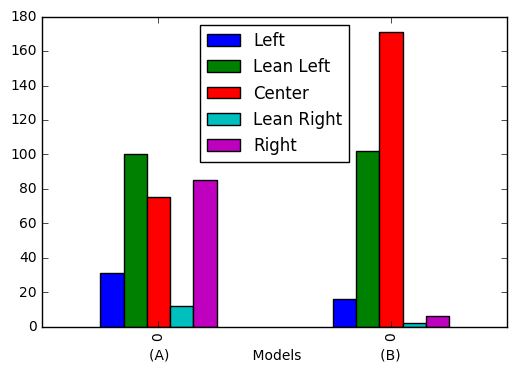

In [284]:
A = pd.DataFrame(data=[[31,100,75,12,85]], columns=['Left','Lean Left','Center','Lean Right','Right'])
B = pd.DataFrame(data=[[16,102,171,2,6]], columns=['Left','Lean Left','Center','Lean Right','Right'])
x = pd.concat([A,B])
print x
x.plot(kind='bar').set_xlabel("(A)                   Models                  (B)")

In [119]:
bothModels_df = pd.concat([modelA_cat_df, modelB_cat_df], axis=1, join='inner')
bothModels_df.columns = ['A_lean', 'A_score', 'A_second_score', 'B_lean', 'B_score', 'B_second_score']

In [120]:
bothModels_df['consistent'] = ''
for i, row in bothModels_df.iterrows():
    value = row.A_lean == row.B_lean
    bothModels_df.set_value(i,'consistent', value)

In [121]:
bothModels_df.head()

,A_lean,A_score,A_second_score,B_lean,B_score,B_second_score,consistent
0,Lean Left,0.343981,0.312428,Center,0.799259,0.061787,False
1,Right,0.403578,0.299196,Center,0.309602,0.204984,False
2,Center,0.676759,0.272350,Center,0.309602,0.204984,True
3,Right,0.827688,0.145149,Center,0.353530,0.225864,False
4,Center,0.999824,0.000174,Lean Left,0.792790,0.075776,False


[[<matplotlib.axes._subplots.AxesSubplot object at 0x14f72ed10>


,A_lean,A_score,A_second_score,B_lean,B_score,B_second_score,consistent
0,Lean Left,0.343981,0.312428,Center,0.799259,0.061787,False
1,Right,0.403578,0.299196,Center,0.309602,0.204984,False
3,Right,0.827688,0.145149,Center,0.353530,0.225864,False
4,Center,0.999824,0.000174,Lean Left,0.792790,0.075776,False
5,Left,0.965168,0.015740,Not rated,0.446893,0.210941,False


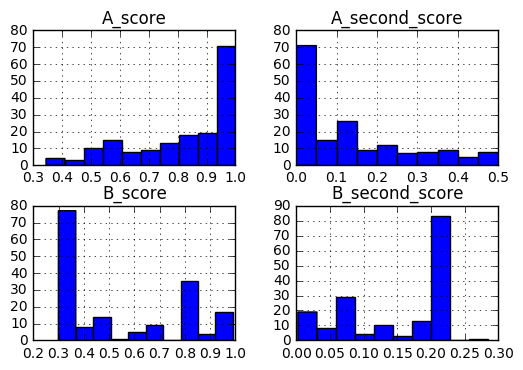

In [122]:
print bothModels_df[bothModels_df.consistent == False].hist()
bothModels_df[bothModels_df.consistent == False].head()

In [124]:
bothModels_df.consistent.value_counts()

False    170
True     142
Name: consistent, dtype: int64

In [125]:
for i in np.arange(0.3,1,0.1):
    print 'Threshold: ' + str(i)
    values = bothModels_df[(bothModels_df.A_score > i) & (bothModels_df.B_score > i)].consistent.value_counts()
    print float(values[True]) / (values[False] + values[True])
    print "T: " + str(values[True]) + " / F: " + str(values[False])
    print " "

Threshold: 0.3
0.460784313725
T: 141 / F: 165
 
Threshold: 0.4
0.55
T: 110 / F: 90
 
Threshold: 0.5
0.594285714286
T: 104 / F: 71
 
Threshold: 0.6
0.62893081761
T: 100 / F: 59
 
Threshold: 0.7
0.671428571429
T: 94 / F: 46
 
Threshold: 0.8
0.847826086957
T: 78 / F: 14
 
Threshold: 0.9
0.941176470588
T: 64 / F: 4
 


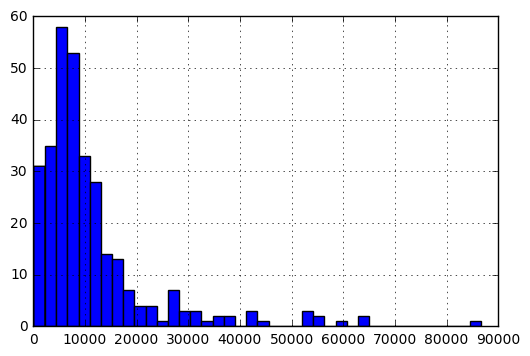

In [140]:
political_folder.cleaned_text.str.len().hist(bins=40)

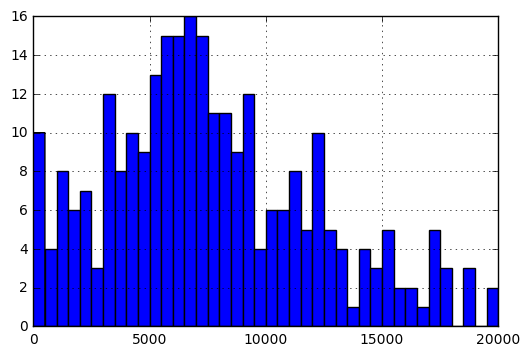

In [139]:
political_folder.cleaned_text.str.len().hist(bins=40, range=[0, 20000])

In [177]:
pld_text['length'] = pld_text['cleaned_text'].str.len()
hash = {'Left': 1, 'Lean Left': 2, 'Center': 3, 'Lean Right': 4, 'Right': 5, 'Mixed': 0, 'Not rated': -1}
# pld_text['political lean integer'] = pld_text['political lean'].apply(lambda x: 1 if x == 'Left' else 2 if x == 'Lean Left' else 3 if x == 'Center' else 4 if x == 'Lean Right' else 5 if x == 'Right' else 0)
pld_text['political lean integer'] = pld_text['political lean'].apply(lambda x: hash[x])

/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


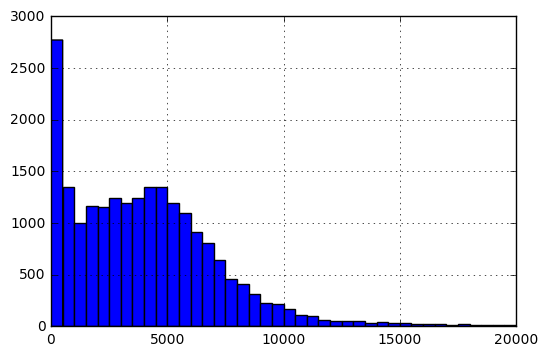

In [202]:
pld_text['length'].hist(bins=40, range=[0, 20000])

In [209]:
print np.percentile(pld_text['length'],20)
print np.percentile(pld_text[pld_text['political lean'] == 'Right']['length'],20)
print np.percentile(pld_text[pld_text['political lean'] == 'Lean Right']['length'],20)
print np.percentile(pld_text[pld_text['political lean'] == 'Center']['length'],20)
print np.percentile(pld_text[pld_text['political lean'] == 'Lean Left']['length'],20)
print np.percentile(pld_text[pld_text['political lean'] == 'Left']['length'],20)

1066.0
1381.2
1819.0
435.0
3568.0
1883.4


Axes(0.125,0.125;0.775x0.775)
Axes(0.125,0.125;0.775x0.775)


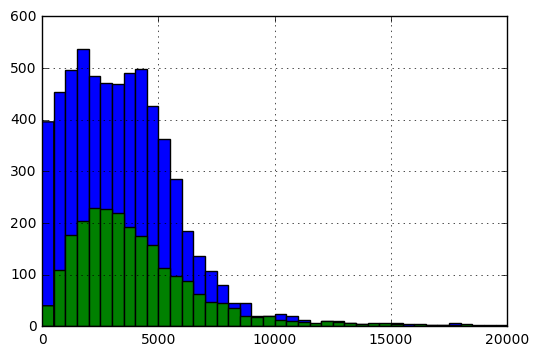

In [324]:
print pld_text[pld_text['political lean'] == 'Right'].length.hist(bins=40, range=[0, 20000])
print pld_text[pld_text['political lean'] == 'Left'].length.hist(bins=40, range=[0, 20000])

Axes(0.125,0.125;0.775x0.775)
Axes(0.125,0.125;0.775x0.775)


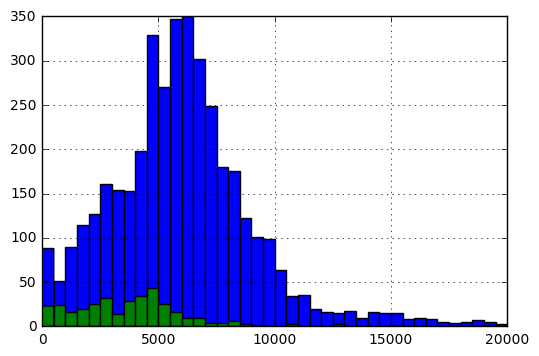

In [326]:
print pld_text[pld_text['political lean'] == 'Lean Left'].length.hist(bins=40, range=[0, 20000])
print pld_text[pld_text['political lean'] == 'Lean Right'].length.hist(bins=40, range=[0, 20000])

Axes(0.125,0.125;0.775x0.775)


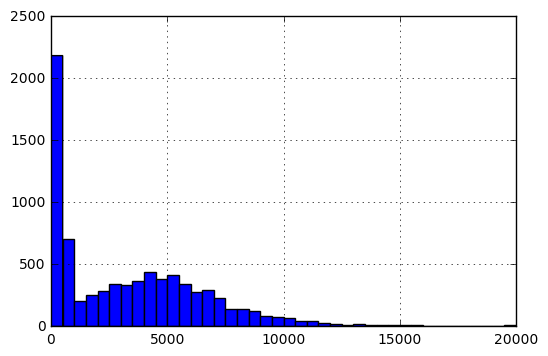

In [198]:
print pld_text[pld_text['political lean'] == 'Center'].length.hist(bins=40, range=[0, 20000])

In [215]:
time = datetime.datetime.now()
modelA = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(ngram_range=(1,2), min_df=4))
    ])),
    ('domain', Domain()),
    ('url', Url())
  ])),
  ('logreg', LogisticRegression())
])

modelA.fit_transform(pld_text[pld_text['length'] > 1500], pld_text[pld_text['length'] > 1500]['political lean'])
print datetime.datetime.now() - time

/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0:04:41.666818


In [216]:
pf_text = political_folder[political_folder.cleaned_text.str.len() > 1500]

modelA_result2 = modelA.predict(pf_text)
modelB_result2 = modelB.predict(pf_text)

modelA_proba_result2 = modelA.predict_proba(pf_text)
modelB_proba_result2 = modelB.predict_proba(pf_text)

highestA2 = []
second_highest_a2 = []
for p in modelA_proba_result2:
    highestA2.append(max(p))
    second_highest_a2.append(heapq.nlargest(2, p)[1])
    
highestB2 = []
second_highest_b2 = []
for p in modelB_proba_result2:
    highestB2.append(max(p))
    second_highest_b2.append(heapq.nlargest(2, p)[1])

modelA_proba_df2 = pd.DataFrame(data=modelA_proba_result2, columns=['Center','Lean Left','Lean Right','Left','Mixed','Not Rated','Right'])
modelB_proba_df2 = pd.DataFrame(data=modelB_proba_result2, columns=['Center','Lean Left','Lean Right','Left','Mixed','Not Rated','Right'])
modelA_cat_df2 = pd.DataFrame(data={'political_lean': modelA_result2, 'pl_score': highestA2, 'pl_2': second_highest_a2}, columns=['political_lean','pl_score', 'pl_2'])
modelB_cat_df2 = pd.DataFrame(data={'political_lean': modelB_result2, 'pl_score': highestB2, 'pl_2': second_highest_b2}, columns=['political_lean', 'pl_score', 'pl_2'])
modelA_df2 = pd.concat([modelA_cat_df2, modelA_proba_df2], axis=1, join='inner')
modelB_df2 = pd.concat([modelB_cat_df2, modelB_proba_df2], axis=1, join='inner')
modelA_df2.head()

,political_lean,pl_score,pl_2,Center,Lean Left,Lean Right,Left,Mixed,Not Rated,Right
0,Lean Left,0.753130,0.108662,0.034689,0.753130,5.415043e-03,0.095614,3.261943e-05,2.457392e-03,0.108662
1,Lean Left,0.804890,0.141231,0.141231,0.804890,1.662815e-05,0.000107,1.477528e-12,1.704622e-04,0.053585
2,Right,0.970709,0.013236,0.005250,0.010504,2.138106e-04,0.013236,1.250035e-09,8.700429e-05,0.970709
3,Lean Left,0.650122,0.224990,0.124788,0.650122,4.193505e-16,0.224990,2.413786e-42,4.240705e-16,0.000101
4,Left,0.918455,0.056369,0.056369,0.023586,2.585722e-04,0.918455,2.383562e-09,1.177747e-05,0.001321


In [217]:
modelA_df2.political_lean.value_counts()

Lean Left     102
Right          88
Center         59
Left           36
Lean Right      5
Name: political_lean, dtype: int64

In [322]:
pld_text.url_domain.value_counts().head(20)

foxnews.com           2521
cnn.com               2356
washingtonpost.com    2247
wsj.com               1806
huffingtonpost.com    1658
townhall.com          1510
politico.com          1237
theblaze.com           986
npr.org                858
nytimes.com            805
csmonitor.com          666
usatoday.com           533
salon.com              521
vox.com                411
breitbart.com          311
newsmax.com            296
cbn.com                157
thedailybeast.com      116
latimes.com            106
factcheck.org          104
Name: url_domain, dtype: int64